In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import sentencepiece as spm
import gensim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
import torch
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import numpy as np
import random
import math

/Users/beesamprajveenkumar/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_json('/Users/beesamprajveenkumar/Documents/Projects/MLX/Tiny_Stories-Transformers/app/train_data.json', lines=True)

In [3]:
train_df.head()

,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."


In [4]:
train_df = train_df[:5000]
train_df.head()

,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."


In [5]:
val_df = pd.read_json('/Users/beesamprajveenkumar/Documents/Projects/MLX/Tiny_Stories-Transformers/app/validation_data.json', lines=True)

In [6]:
val_df = val_df[:200]
val_df.head()

,text
0,"Spot. Spot saw the shiny car and said, ""Wow, K..."
1,"Once upon a time, in a big forest, there lived..."
2,"Once upon a time, in a small yard, there was a..."
3,"Once upon a time, there was a thoughtful girl ..."
4,"Once upon a time, there was a kind farmer. He ..."


In [7]:
def generate_inputs_and_labels(train_df, sp):
    inputs = []
    labels = []

    for index, row in train_df.iterrows():
        text = row['text']
        tokens = text.split()  # Tokenize the text by splitting on whitespace

        # Generate input by adding start of sentence token at the beginning
        input_sequence = tokens

        # Generate label by adding end of sentence token at the end
        label_sequence = tokens

        inputs.append(input_sequence)
        labels.append(label_sequence)

    # Convert input and label sequences to strings
    input_strings = [' '.join(sequence) for sequence in inputs]
    label_strings = [' '.join(sequence) for sequence in labels]

    # Tokenize input strings and add <sos> token at the beginning
    tokenized_inputs = []
    input_ids = []
    for sequence in input_strings:
        tokenized_sequence = sp.encode_as_pieces(sequence)
        tokenized_sequence = ['<sos>'] + tokenized_sequence  # Add <sos> token manually
        input_ids.append([sp.piece_to_id('<sos>')] + sp.encode_as_ids(sequence))  # Get token IDs
        tokenized_inputs.append(tokenized_sequence)

    # Tokenize label strings and add </sos> token at the end
    tokenized_labels = []
    label_ids = []
    for sequence in label_strings:
        tokenized_sequence = sp.encode_as_pieces(sequence)
        tokenized_sequence.append('</sos>')  # Add </sos> token manually at the end
        label_ids.append(sp.encode_as_ids(sequence) + [sp.piece_to_id('</sos>')])  # Get token IDs
        tokenized_labels.append(tokenized_sequence)

    # Print tokenized input and label sequences
    #for i in range(len(inputs)):
        #print("Input Text:", input_strings[i])
        #print("Tokenized Input:", tokenized_inputs[i])
        #print("Input IDs:", input_ids[i])
        #print("\n")
        #print("Label Text:", label_strings[i])
        #print("Tokenized Label:", tokenized_labels[i])
        #print("Label IDs:", label_ids[i])
        #print("------")

    return input_ids, label_ids


In [8]:
# Example usage
sp = spm.SentencePieceProcessor()
sp.load('/Users/beesamprajveenkumar/Documents/Projects/MLX/Tiny_Stories-Transformers/app/small_m.model')

source_ids, target_ids = generate_inputs_and_labels(train_df, sp)

In [9]:
len(source_ids)

10000

In [10]:
# Flatten the list of lists
flat_ids = [item for sublist in source_ids for item in sublist]

# Find the maximum ID
max_id = max(flat_ids)
print("Maximum ID value in source:", max_id)

# Flatten the list of lists
flat_ids = [item for sublist in target_ids for item in sublist]

# Find the maximum ID
max_id = max(flat_ids)
print("Maximum ID value in labels:", max_id)


Maximum ID value in source: 3926
Maximum ID value in labels: 3926


# Transformer

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [12]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        pe = self._init_pe(max_seq_length, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_length = x.size(1)
        pe = self.pe[:seq_length, :] if seq_length <= self.max_seq_length else self._init_pe(seq_length, self.d_model)
        return x + pe

    def _init_pe(self, seq_length, d_model):
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe


In [14]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, decoder_input, decoder_mask):
        attn_output = self.self_attn(decoder_input, decoder_input, decoder_input, decoder_mask)
        x = self.norm1(decoder_input + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [15]:
class Transformer(nn.Module):
    def __init__(self, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, tgt):
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return tgt_mask

    def forward(self, decoder_input):
        decoder_mask = self.generate_mask(decoder_input)
        decoder_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(decoder_input)))

        dec_output = decoder_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, decoder_mask)

        output = self.fc(dec_output)
        return output


# Custom dataset

In [16]:
# Generate input and label sequences
train_source_ids, train_target_ids = generate_inputs_and_labels(train_df, sp)
val_source_ids, val_target_ids = generate_inputs_and_labels(val_df, sp)

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, input_ids, label_ids):
        self.input_ids = input_ids
        self.label_ids = label_ids

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return torch.tensor(self.input_ids[idx]), torch.tensor(self.label_ids[idx])

# Define dataloaders
batch_size = 1
train_dataset = CustomDataset(train_source_ids, train_target_ids)
val_dataset = CustomDataset(val_source_ids, val_target_ids)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [17]:
tgt_vocab_size = 5000
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 512
max_seq_length = 100
dropout = 0.1

In [18]:
transformer = Transformer(tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# Training loop
transformer.train()

train_losses = []
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for input_data, target_data in train_dataloader:
        optimizer.zero_grad()
        output = transformer(input_data)
        
        # Adjust target_data to have the same length as model output
        target_data_adjusted = target_data[:, :output.size(1)]
        
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), target_data_adjusted.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    train_loss = total_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    # Print train and validation loss side by side with 4 decimals
    #if epoch%10==0 or epoch==0:
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}")


Epoch: 1, Train Loss: 3.8291
Epoch: 2, Train Loss: 3.4607
Epoch: 3, Train Loss: 3.3608
Epoch: 4, Train Loss: 3.2930
Epoch: 5, Train Loss: 3.2435


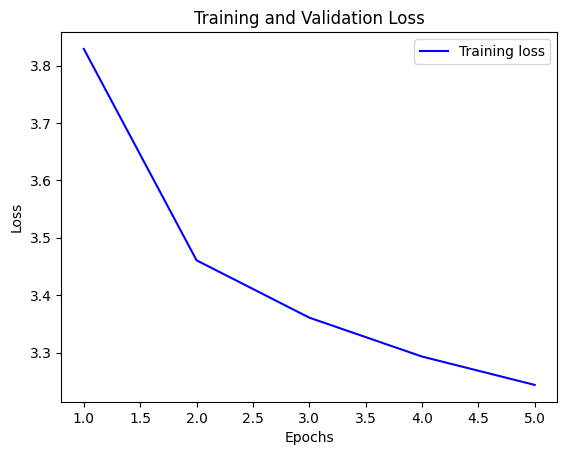

In [19]:

# Plotting the losses
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
# Save the trained model
torch.save(transformer.state_dict(), 'v4.pth')

In [25]:
def word_to_token_id(word, sp_model):
    # Convert word to token ID using SentencePiece
    return sp_model.piece_to_id(word)

def generate_text(model, sp_model, starting_word, ending_word, max_length):
    
    # Convert starting and ending words to token IDs
    starting_token_id = word_to_token_id(starting_word, sp_model)
    if starting_token_id is None:
        raise ValueError(f"Starting word '{starting_word}' not found in vocabulary.")
    
    ending_token_id = word_to_token_id(ending_word, sp_model)
    if ending_token_id is None:
        raise ValueError(f"Ending word '{ending_word}' not found in vocabulary.")
    
    
    generated_sequence = [starting_token_id]
    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.tensor([generated_sequence])
            output = model(input_tensor)
            predicted_token = output.argmax(-1)[:,-1].item()
            generated_sequence.append(predicted_token)
            if predicted_token == ending_token_id:
                break
            
    # Convert token IDs to words using SentencePiece
    generated_text = sp_model.decode_ids(generated_sequence)
    return generated_text

# Example usage:
starting_word = "<sos>"
ending_word = "</sos>"
max_length = 100
generated_sequence = generate_text(transformer, sp, starting_word, ending_word, max_length)
print("Generated sequence:", generated_sequence)

Generated sequence:  ⁇ .!. the boy was happy. the boy was happy. the boy was happy. one day, the boy was sad. the boy. the boy was happy. the boy. the boy. the boy. the boy. the boy was sad. the boy. the boy was sad. the boy was sad. the boy. the boy was sad. the boy. the boy. the boy. the boy was sad. the boy. the boy. the boy was sad. the boy.
